In [ ]:
import os, librosa, numpy as np, pandas as pd # librosa is used for audio processing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns

# For reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# 1. Download TESS Dataset from Kaggle

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ejlok1/toronto-emotional-speech-set-tess")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'toronto-emotional-speech-set-tess' dataset.
Path to dataset files: /kaggle/input/toronto-emotional-speech-set-tess


In [ ]:
ls /kaggle/input/toronto-emotional-speech-set-tess

'tess toronto emotional speech set data'/
'TESS Toronto emotional speech set data'/


In [ ]:
ls /kaggle/input/toronto-emotional-speech-set-tess/'TESS Toronto emotional speech set data'/


OAF_angry/    OAF_neutral/            YAF_disgust/  YAF_pleasant_surprised/
OAF_disgust/  OAF_Pleasant_surprise/  YAF_fear/     YAF_sad/
OAF_Fear/     OAF_Sad/                YAF_happy/
OAF_happy/    YAF_angry/              YAF_neutral/


In [ ]:
DATA_PATH = "/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/"

# sanity check
emotions_dirs = sorted([d for d in os.listdir(DATA_PATH) if os.path.isdir(os.path.join(DATA_PATH, d))])
print("Found emotion folders:", emotions_dirs)

# pick one sample file from one emotion folder
example_emotion_dir = os.path.join(DATA_PATH, emotions_dirs[0])
example_file = [f for f in os.listdir(example_emotion_dir) if f.endswith(".wav")][0]
example_path = os.path.join(example_emotion_dir, example_file)

print("Example file:", example_path)

y, sr = librosa.load(example_path, duration=3.0)
print("Audio length (samples):", len(y), " Sample rate:", sr)


Found emotion folders: ['OAF_Fear', 'OAF_Pleasant_surprise', 'OAF_Sad', 'OAF_angry', 'OAF_disgust', 'OAF_happy', 'OAF_neutral', 'YAF_angry', 'YAF_disgust', 'YAF_fear', 'YAF_happy', 'YAF_neutral', 'YAF_pleasant_surprised', 'YAF_sad']
Example file: /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/OAF_Fear/OAF_gap_fear.wav
Audio length (samples): 37220  Sample rate: 22050


In [ ]:
from IPython.display import Audio, display

display(Audio(data=y, rate=sr))

# Waveform (raw signal amplitude)

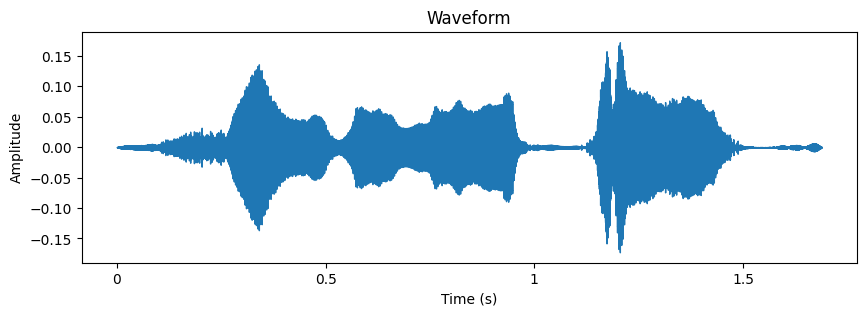

In [ ]:
#@title Wave form
plt.figure(figsize=(10, 3))
librosa.display.waveshow(y, sr=sr)
plt.title('Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()


# Spectrogram (energy per frequency over time)

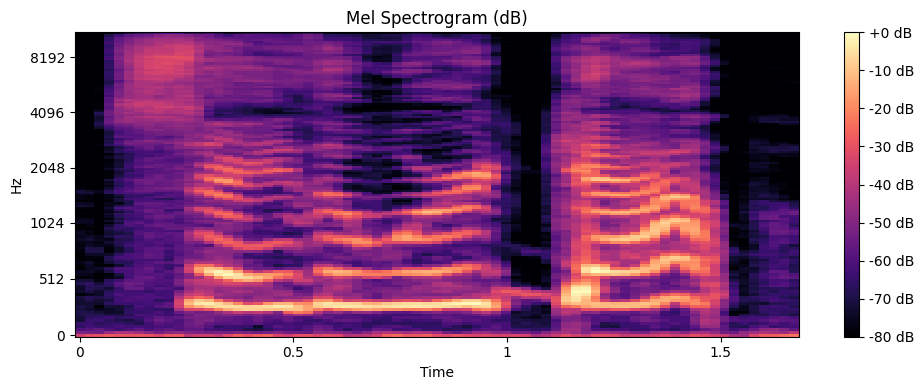

In [ ]:
#@title Mel Spectrogram
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
S_dB = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(10, 4))
librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram (dB)')
plt.tight_layout()
plt.show()


# MFCCs (compressed frequency representation)

---



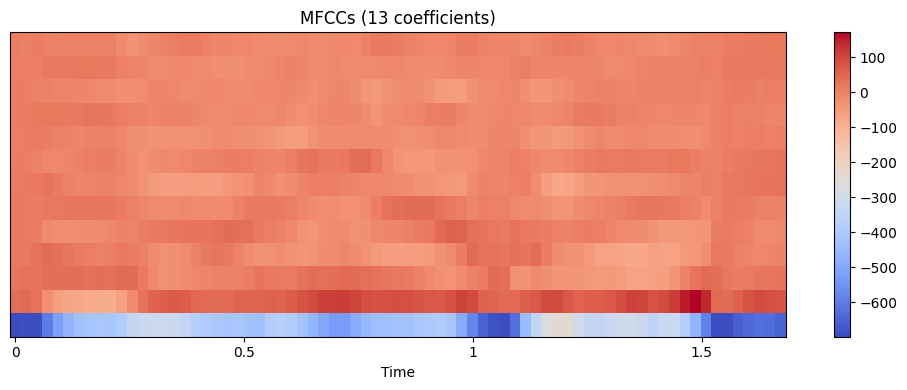

In [ ]:
#@title MFCC Heatmap
mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

plt.figure(figsize=(10, 4))
librosa.display.specshow(mfcc, x_axis='time', sr=sr)
plt.colorbar()
plt.title('MFCCs (13 coefficients)')
plt.tight_layout()
plt.show()


In [ ]:
print(mfcc.shape)
m = np.mean(mfcc.T, axis=0)
print(m.shape)
print(m)


(13, 73)
(13,)
[-451.5639      59.601387     3.9785483  -13.838255     1.1945617
    3.2228322  -16.634869     0.7306471  -16.97427     -3.3365085
  -12.520986    -4.1565905   -2.8561172]


# Chroma (pitch class intensity)
useful for tone/emotion

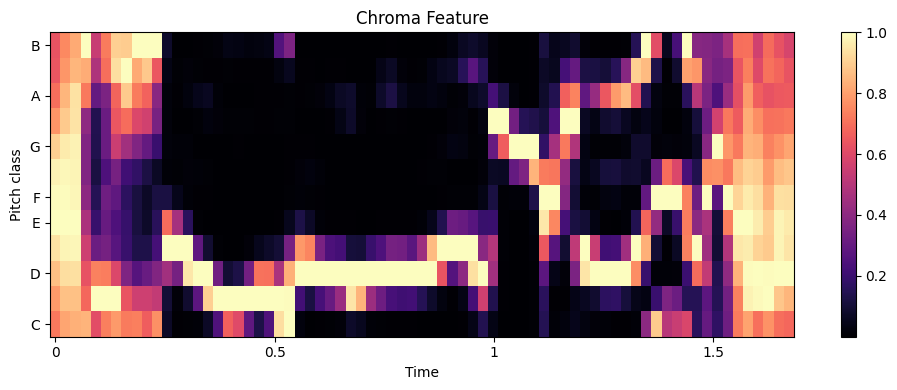

In [ ]:
chroma = librosa.feature.chroma_stft(y=y, sr=sr)

plt.figure(figsize=(10, 4))
librosa.display.specshow(chroma, y_axis='chroma', x_axis='time', sr=sr)
plt.colorbar()
plt.title('Chroma Feature')
plt.tight_layout()
plt.show()

In [ ]:
print(chroma.shape)
m = np.mean(chroma.T, axis=0)
print(m.shape)
print(m)

(12, 73)
(12,)
[0.29541513 0.43679574 0.6330266  0.4599649  0.27202317 0.27339733
 0.25152242 0.2577514  0.25006807 0.26962516 0.272161   0.26440695]


In [ ]:
def extract_features(file_path, max_duration=3.0, offset=0.5):
    """
    Load audio, cut/pad it to a fixed window, and compute summary features.
    """
    y, sr = librosa.load(file_path, duration=max_duration, offset=offset)

    # MFCCs (shape: [n_mfcc, frames]) -> average over time axis
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfcc_mean = np.mean(mfcc.T, axis=0)

    # Chroma (12 pitch classes)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    chroma_mean = np.mean(chroma.T, axis=0)

    # Zero Crossing Rate
    zcr = librosa.feature.zero_crossing_rate(y)
    zcr_mean = np.mean(zcr)

    # Spectral centroid
    spec_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    spec_centroid_mean = np.mean(spec_centroid)

    # Concatenate all features into one vector
    feature_vector = np.hstack([mfcc_mean, chroma_mean, zcr_mean, spec_centroid_mean])
    return feature_vector

In [ ]:
# def extract_features(file_path, max_duration=3.0, offset=0.5):
#     """
#     Extract a comprehensive set of features from an audio file.
#     Returns a 1D numpy array (feature vector).
#     """
#     try:
#         y, sr = librosa.load(file_path, duration=max_duration, offset=offset)

#         # --- 1. MFCCs (13 coefficients) ---
#         mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
#         mfcc_mean = np.mean(mfcc.T, axis=0)

#         # --- 2. Chroma ---
#         chroma = librosa.feature.chroma_stft(y=y, sr=sr)
#         chroma_mean = np.mean(chroma.T, axis=0)

#         # --- 3. Mel Spectrogram ---
#         mel = librosa.feature.melspectrogram(y=y, sr=sr)
#         mel_mean = np.mean(mel.T, axis=0)

#         # --- 4. Spectral Centroid ---
#         spec_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
#         spec_centroid_mean = np.mean(spec_centroid)

#         # --- 5. Spectral Rolloff ---
#         spec_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
#         spec_rolloff_mean = np.mean(spec_rolloff)

#         # --- 6. Spectral Bandwidth ---
#         spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
#         spec_bw_mean = np.mean(spec_bw)

#         # --- 7. Zero Crossing Rate ---
#         zcr = librosa.feature.zero_crossing_rate(y)
#         zcr_mean = np.mean(zcr)

#         # --- 8. RMS Energy ---
#         rms = librosa.feature.rms(y=y)
#         rms_mean = np.mean(rms)

#         # Combine all features into a single vector
#         feature_vector = np.hstack([
#             mfcc_mean,
#             chroma_mean,
#             mel_mean,
#             [spec_centroid_mean, spec_rolloff_mean, spec_bw_mean, zcr_mean, rms_mean]
#         ])

#         return feature_vector

#     except Exception as e:
#         print(f"Error processing {file_path}: {e}")
#         return None

# 2. Extract Features

In [ ]:
 # "TESS_Toronto_emotions/"
emotions = {"OAF_angry/": "angry",
           "OAF_disgust/": "disgust",
           "OAF_Fear/": "fear",
           "OAF_happy/": "happy",
           "OAF_neutral/": "neutral",
           "OAF_Sad/": "sad",
           "OAF_Pleasant_surprise/": "surprise",
           "YAF_angry/": "angry",
           "YAF_disgust/": "disgust",
           "YAF_fear/": "fear",
           "YAF_happy/": "happy",
           "YAF_sad/": "sad",
           "YAF_neutral/": "neutral",
           "YAF_pleasant_surprised/": "surprise"}
# emotions = os.listdir(DATA_PATH)

X, y = [], []
for path, emotion in emotions.items():
    folder = os.path.join(DATA_PATH, path)
    for file in os.listdir(folder):
        if file.endswith(".wav"):
            features = extract_features(os.path.join(folder, file))
            X.append(features)
            y.append(emotion.lower())

X, y = np.array(X), np.array(y)
print("Feature matrix:", X.shape)
print("Unique labels:", np.unique(y))

Feature matrix: (2800, 27)
Unique labels: ['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']


# 3. Encode target and split

In [ ]:
encoder = LabelEncoder()
y_enc = encoder.fit_transform(y)

for i in range(10):
  print("Original Label:", y[i] ,"| Encoded label:", y_enc[i])


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_enc, test_size=0.2, random_state=42, stratify=y_enc)
num_classes = len(np.unique(y_enc))

print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)

Original Label: angry | Encoded label: 0
Original Label: angry | Encoded label: 0
Original Label: angry | Encoded label: 0
Original Label: angry | Encoded label: 0
Original Label: angry | Encoded label: 0
Original Label: angry | Encoded label: 0
Original Label: angry | Encoded label: 0
Original Label: angry | Encoded label: 0
Original Label: angry | Encoded label: 0
Original Label: angry | Encoded label: 0
Training data shape: (2240, 27)
Testing data shape: (560, 27)


# Baseline Model with Random Forest

In [ ]:
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

print("=== Random Forest Results ===")
print(classification_report(y_test, y_pred_rf, target_names=encoder.classes_))


=== Random Forest Results ===
              precision    recall  f1-score   support

       angry       0.91      0.94      0.93        80
     disgust       0.91      0.93      0.92        80
        fear       0.95      0.97      0.96        80
       happy       0.95      0.90      0.92        80
     neutral       0.99      1.00      0.99        80
         sad       0.99      1.00      0.99        80
    surprise       0.91      0.88      0.89        80

    accuracy                           0.94       560
   macro avg       0.94      0.94      0.94       560
weighted avg       0.94      0.94      0.94       560



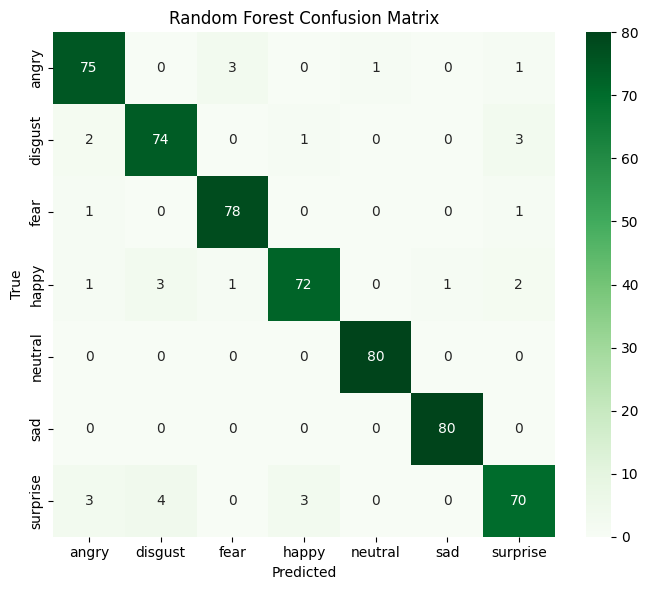

In [ ]:
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(7,6))
sns.heatmap(cm_rf,
            annot=True,
            fmt='d',
            cmap='Greens',
            xticklabels=encoder.classes_,
            yticklabels=encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Random Forest Confusion Matrix')
plt.tight_layout()
plt.show()


In [ ]:
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat  = to_categorical(y_test, num_classes)

model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,295 (48.03 KB)

 Trainable params: 12,295 (48.03 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(min_delta=0.001,
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    X_train,
    y_train_cat,
    validation_data=(X_test, y_test_cat),
    epochs=60,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

loss, acc = model.evaluate(X_test, y_test_cat, verbose=0)
print(f"Neural Network Accuracy on test set: {acc:.3f}")

y_pred_nn_prob = model.predict(X_test)
y_pred_nn = np.argmax(y_pred_nn_prob, axis=1)

print("=== Neural Network Results ===")
print(classification_report(y_test, y_pred_nn, target_names=encoder.classes_))


Epoch 1/60
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9921 - loss: 0.0290 - val_accuracy: 0.9857 - val_loss: 0.0732
Epoch 2/60
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9985 - loss: 0.0108 - val_accuracy: 0.9839 - val_loss: 0.0755
Epoch 3/60
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9955 - loss: 0.0172 - val_accuracy: 0.9857 - val_loss: 0.0823
Epoch 4/60
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9924 - loss: 0.0169 - val_accuracy: 0.9857 - val_loss: 0.0828
Epoch 5/60
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9963 - loss: 0.0139 - val_accuracy: 0.9804 - val_loss: 0.0823
Epoch 6/60
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9962 - loss: 0.0143 - val_accuracy: 0.9857 - val_loss: 0.0768
Epoch 7/60
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9930 - loss: 0.0283 - val_accuracy: 0.9839 - val_loss: 0.0751
Epoch 8/60
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9951 - loss: 0.0172 - val_accuracy: 0.9804 - val_loss

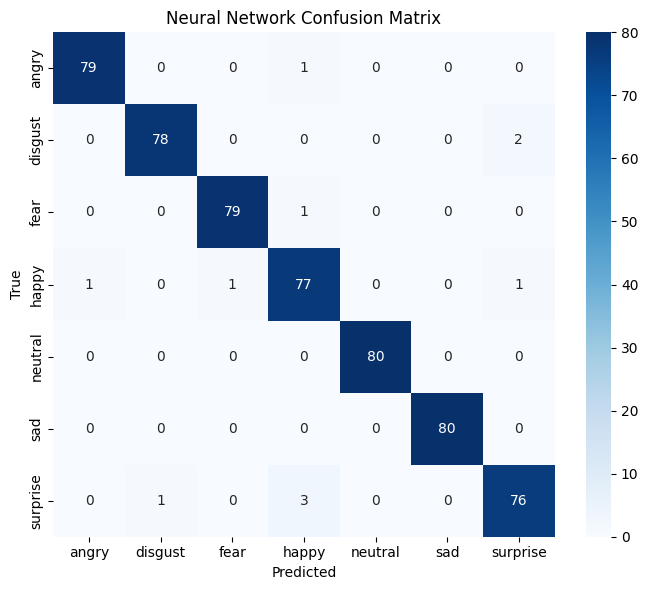

In [ ]:
cm_nn = confusion_matrix(y_test, y_pred_nn)
plt.figure(figsize=(7,6))
sns.heatmap(cm_nn,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=encoder.classes_,
            yticklabels=encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Neural Network Confusion Matrix')
plt.tight_layout()
plt.show()


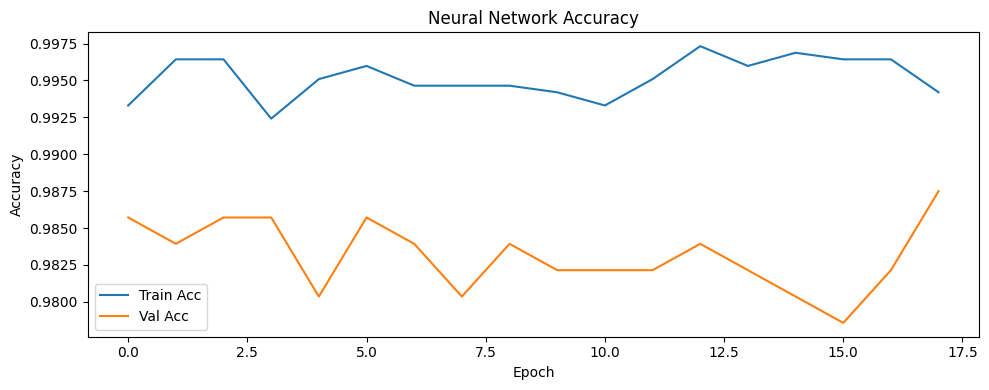

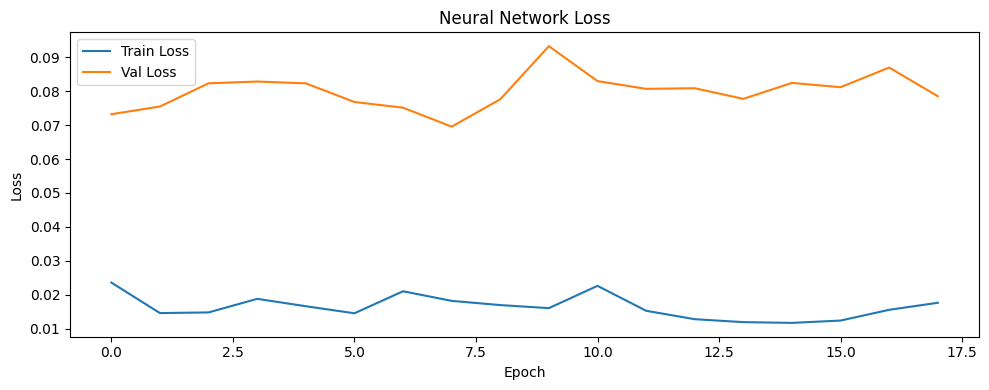

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Neural Network Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Neural Network Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()
